In [1]:
from BioLink.biolink_client import BioLinkWrapper
import pandas as pd
from pprint import pprint
from collections import defaultdict
import json
import graphviz as gv
from mygene import MyGeneInfo

In [2]:
# instantiate helpers
blw = BioLinkWrapper()
mg = MyGeneInfo()

In [3]:
def conv_pref(prefix):
    return prefix.replace(':', '_')

def map_id(in_id):
    return blw.get_obj(obj_id=in_id)['id']

# Workflow 2 
## Progeria implementation

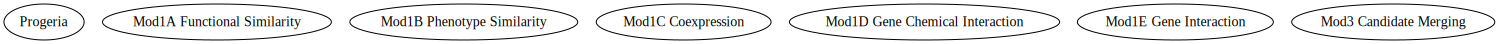

In [4]:
# workflow input is a disease identifier, and label tuple
input_disease = ('MONDO:0008310', 'Progeria')



# Begin Graphviz representation of workflow
wf2_graph = gv.Digraph(name="Workfow II {} Implementation".format(input_disease[1]))
wf2_graph.node(conv_pref(input_disease[0]), label=input_disease[1])
wf2_graph.node('Mod1A', label='Mod1A Functional Similarity')
wf2_graph.node('Mod1B', label='Mod1B Phenotype Similarity')
wf2_graph.node('Mod1C', label='Mod1C Coexpression')
wf2_graph.node('Mod1D', label='Mod1D Gene Chemical Interaction')
wf2_graph.node('Mod1E', label='Mod1E Gene Interaction')
wf2_graph.node('Mod3', label='Mod3 Candidate Merging')
wf2_graph

### Get Disease associated genes from BioLink API api.monarchinitative.org

In [5]:
input_genes = blw.disease2genes(input_disease[0])
input_genes = [blw.parse_association(input_disease[0], input_disease[1], x) for x in input_genes['associations']]
for input_gene in input_genes:
    igene_mg = mg.query(input_gene['hit_id'].replace('HGNC', 'hgnc'), species='human', entrezonly=True, fields='entrez,HGNC,symbol')
    input_gene.update({'ncbi': 'NCBIGene:{}'.format(igene_mg['hits'][0]['_id'])})
    
input_genes_df = pd.DataFrame(data=input_genes)
# group duplicate ids and gather sources
input_genes_df['sources'] = input_genes_df['sources'].str.join(', ')
input_genes_df = input_genes_df.groupby(['input_id', 'input_label', 'hit_id','hit_label', 'ncbi'])['sources'].apply(', '.join).reset_index()

In [6]:
input_genes_df

,input_id,input_label,hit_id,hit_label,ncbi,sources
0,MONDO:0008310,Progeria,HGNC:12877,ZMPSTE24,NCBIGene:10269,"ctd, orphane"
1,MONDO:0008310,Progeria,HGNC:17397,BANF1,NCBIGene:8815,"omim, ctd, orphane, clinvar"
2,MONDO:0008310,Progeria,HGNC:25356,SPRTN,NCBIGene:83932,ctd
3,MONDO:0008310,Progeria,HGNC:494,ANK3,NCBIGene:288,ctd
4,MONDO:0008310,Progeria,HGNC:6636,LMNA,NCBIGene:4000,"ctd, omim, orphane, clinvar, corie"
5,MONDO:0008310,Progeria,HGNC:9721,PYCR1,NCBIGene:5831,ctd


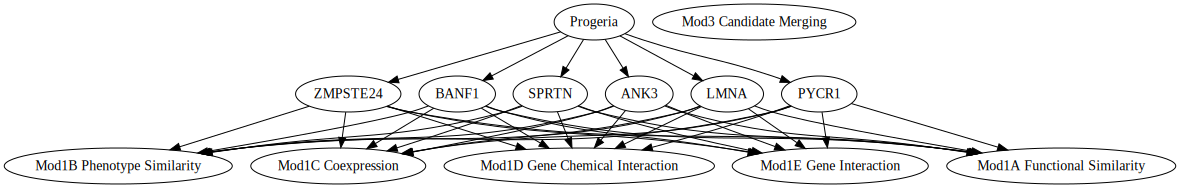

In [7]:
# graph fanconi genes 2 mod1
for index, row in input_genes_df.iterrows():
    wf2_graph.node(conv_pref(row[2]), label=row[3])
    wf2_graph.edge(conv_pref(input_disease[0]), conv_pref(row[2]))
    modules = ['Mod1A', 
               'Mod1B', 
               'Mod1C', 
               'Mod1D', 
               'Mod1E']
    for mod in modules:
        wf2_graph.edge(conv_pref(row[2]), mod)
    
wf2_graph

In [8]:
mod1_candidates = list()

# Mod1A Functional Similarity

In [9]:
from Modules.Mod1A_functional_sim import FunctionalSimilarity

func_sim = FunctionalSimilarity()
func_sim.load_gene_set(input_genes_df['hit_id'].tolist()) 
func_sim.load_associations() 
Mod1A_results = pd.DataFrame(func_sim.compute_similarity(lower_bound=0.55))
Mod1A_results = Mod1A_results[~Mod1A_results['sim_hit_name'].isin(input_genes_df['hit_label'])]
Mod1A_results

/Users/tputman/.virtualenvs/modules/lib/python3.6/site-packages/cachier/mongo_core.py:24: UserWarning: Cachier warning: pymongo was not found. MongoDB cores will not work.
  "Cachier warning: pymongo was not found. MongoDB cores will not work.")


,input_curie,sim_hit_curie,sim_hit_name,sim_score
2,HGNC:25356,UniProtKB:O14519,CDK2AP1,0.552239
3,HGNC:25356,UniProtKB:Q6NZ36,FAAP20,0.588235
4,HGNC:25356,UniProtKB:Q6ZNA4,RNF111,0.567901
5,HGNC:25356,UniProtKB:Q96MG7,NSMCE3,0.572414
6,HGNC:25356,UniProtKB:Q96PM5,RCHY1,0.587879
8,HGNC:25356,UniProtKB:Q9NVI1,FANCI,0.666667
9,HGNC:25356,UniProtKB:Q9UBZ9,REV1,0.561983
13,HGNC:9721,UniProtKB:Q96C36,PYCR2,0.587719


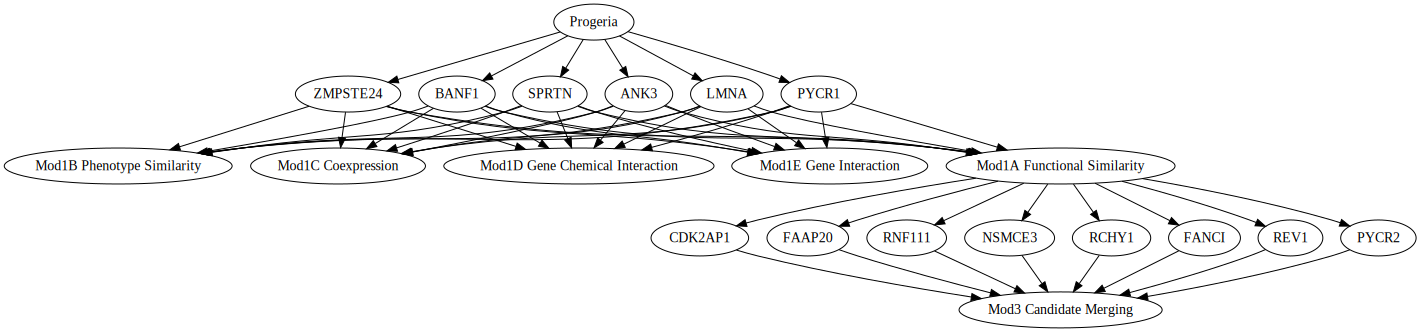

In [10]:
# graph mod1A genes 2 Mod3
for index, row in Mod1A_results.iterrows():
    wf2_graph.node(conv_pref(row[1]), label=row[2])
    wf2_graph.edge('Mod1A', conv_pref(row[1]))
    wf2_graph.edge(conv_pref(row[1]), 'Mod3')
    mod1_candidates.append({
        'input_curie': row[0],
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1A'
    })
wf2_graph

# Mod1B Phenotype Similarity

In [11]:
from Modules.Mod1B_phenotype_similarity import PhenotypeSimilarity

pheno_sim = PhenotypeSimilarity()
pheno_sim.load_gene_set(input_genes_df['hit_id'].tolist()) # TODO run on all fa genes
pheno_sim.load_associations()
Mod1B_results = pheno_sim.similarity_search()

'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13caa1b70>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13caa1fd0>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe048>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe3c8>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe400>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe7b8>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe7f0>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe8d0>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe940>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabe9b0>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabeac8>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabeba8>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13cabef28>
'label' <SimSearch.simsearch_client.SimScoreMatch o

In [12]:
Mod1B_results = Mod1B_results[~Mod1B_results['label_x'].isin(input_genes_df['hit_label'])]
Mod1B_results = Mod1B_results[~Mod1B_results['id'].str.contains('MONDO')]
Mod1B_results = Mod1B_results[Mod1B_results['summed_score'] > 100]
Mod1B_results['hit_id'] = Mod1B_results['id'].apply(map_id)

In [13]:
Mod1B_results

,input_id_x,id,label_x,summed_score,hit_id
12,HGNC:12877,OMIM:600275,NOTCH2,143.0,HGNC:7882
16,HGNC:12877,OMIM:612373,SLC29A3,135.0,HGNC:23096
18,HGNC:12877,OMIM:173325,JUP,133.0,HGNC:6207
20,HGNC:12877,OMIM:120180,COL3A1,133.0,HGNC:2201
22,HGNC:12877,OMIM:615291,B3GALT6,132.0,HGNC:17978
42,HGNC:12877,OMIM:611716,ATP6V0A2,131.0,HGNC:18481
52,HGNC:12877,OMIM:601105,CTSK,141.0,HGNC:2536
67,HGNC:12877,OMIM:300017,FLNA,130.0,HGNC:3754
71,HGNC:12877,HGNC:38881,MIR3606,130.0,HGNC:38881
75,HGNC:12877,OMIM:605497,CRTAP,132.0,HGNC:2379


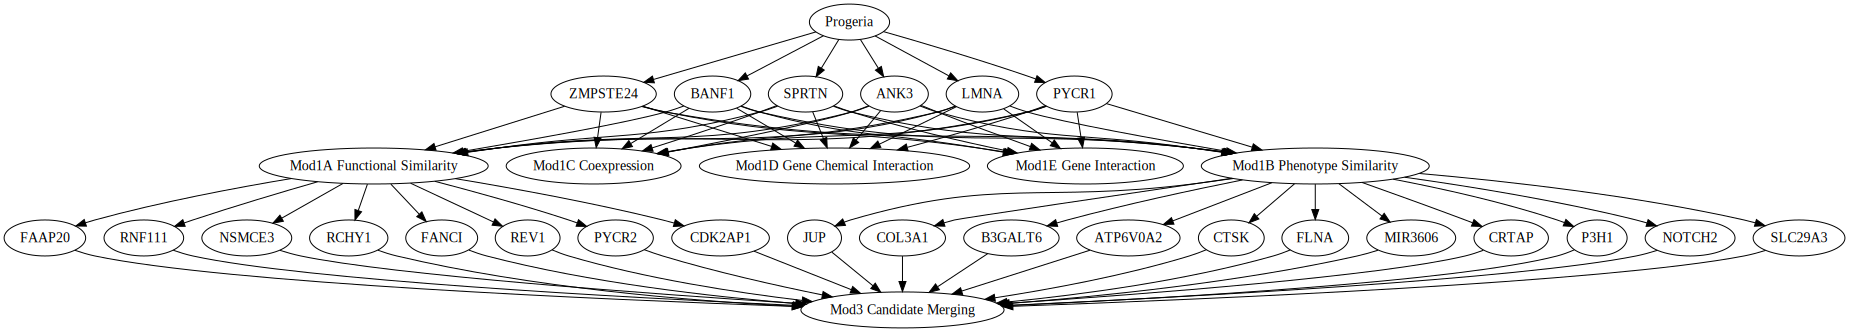

In [14]:
# graph mod1B genes 2 Mod3
for index, row in Mod1B_results.iterrows():
    wf2_graph.node(conv_pref(row[-1]), label=row[2])
    wf2_graph.edge('Mod1B', conv_pref(row[-1]))
    wf2_graph.edge(conv_pref(row[-1]), 'Mod3')
    mod1_candidates.append({
        'input_curie': row[0],
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1B'
    })
wf2_graph

# Mod1C Coexpression

In [15]:
# TODO

# Mod1D Chemical Gene Interactions

In [16]:
# Needs work, way too many hits 

In [17]:
# increases expression instance
# from Modules.Mod1D_Chemical_Gene import ChemicalGeneInteractions

In [18]:
# use only fa core genes 
# fa_core_genes = ['FANCA','FANCB','FANCC','FANCE','FANCF','FANCG','FANCL','FANCM','FANCD2','FANCI','UBE2T','SLX4']
# fa_genes_df[fa_genes_df['hit_label'].str.contains('|'.join(fa_core_genes))]

In [19]:
# gci = ChemicalGeneInteractions()
# gci.load_gene_set(gene_set=fa_genes_df[fa_genes_df['hit_label'].str.contains('|'.join(fa_core_genes))])
# only return chemicals that decrease expression of fa genes
# gci.get_chemicals(action='decreases^expression')
# gci.load_gene_hits(action='decreases^expression', rows=2)

# Mod1E Gene Interactions

In [20]:
from Modules.Mod1E_interactions import GeneInteractions

gene_inter = GeneInteractions()
gene_inter.load_gene_set(gene_set=input_genes_df['hit_id'].tolist())
gene_inter.get_interactions()
Mod1E_results = pd.DataFrame(gene_inter.interactions)

In [21]:
Mod1E_results = Mod1E_results[~Mod1E_results['hit_label'].isin(input_genes_df['hit_label'])]

In [22]:
grouped_Mod1E_results = Mod1E_results.groupby(['hit_id','hit_label'])['input_id'].apply(', '.join).reset_index()

In [23]:
grouped_Mod1E_results.head()

,hit_id,hit_label,input_id
0,HGNC:1006,BCL7C,"HGNC:17397, HGNC:25356"
1,HGNC:10061,RNF2,"HGNC:494, HGNC:9721"
2,HGNC:10289,RPA1,HGNC:25356
3,HGNC:10290,RPA2,HGNC:25356
4,HGNC:10291,RPA3,HGNC:25356


In [28]:
trimmed_Mod1E_results = list()
for index, row in grouped_Mod1E_results.iterrows():
    if len(row[-1].split(',')) > 10:
        trimmed_Mod1E_results.append(row)
Mod1E_results = pd.DataFrame(trimmed_Mod1E_results, columns=['hit_id', 'hit_label', 'input_id'])
Mod1E_results   

,hit_id,hit_label,input_id


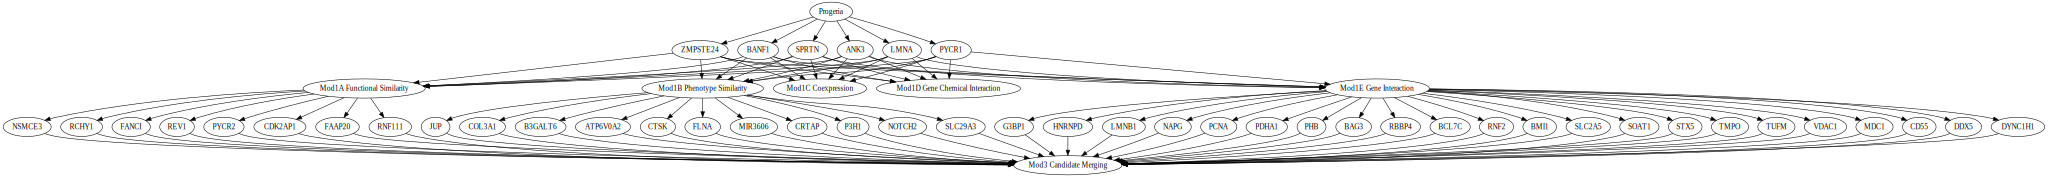

In [29]:
# graph mod1E genes 2 Mod3
for index, row in Mod1E_results.iterrows():
    wf2_graph.node(conv_pref(row[0]), label=row[1])
    wf2_graph.edge('Mod1E', conv_pref(row[0]))
    wf2_graph.edge(conv_pref(row[0]), 'Mod3')
    mod1_candidates.append({
        'input_curie': row[-1],
        'output_curie': row[0],
        'output_name': row[1],
        'module': 'Mod1E',
    })
wf2_graph

In [26]:
pd.DataFrame(mod1_candidates)

,input_curie,module,output_curie,output_name
0,HGNC:25356,Mod1A,UniProtKB:O14519,CDK2AP1
1,HGNC:25356,Mod1A,UniProtKB:Q6NZ36,FAAP20
2,HGNC:25356,Mod1A,UniProtKB:Q6ZNA4,RNF111
3,HGNC:25356,Mod1A,UniProtKB:Q96MG7,NSMCE3
4,HGNC:25356,Mod1A,UniProtKB:Q96PM5,RCHY1
5,HGNC:25356,Mod1A,UniProtKB:Q9NVI1,FANCI
6,HGNC:25356,Mod1A,UniProtKB:Q9UBZ9,REV1
7,HGNC:9721,Mod1A,UniProtKB:Q96C36,PYCR2
8,HGNC:12877,Mod1B,OMIM:600275,NOTCH2
9,HGNC:12877,Mod1B,OMIM:612373,SLC29A3


In [27]:
wf2_graph.render()

'Workfow II Progeria Implementation.gv.pdf'